In [1]:
%load_ext autoreload
%autoreload 2

# fundamentals
import os, sys
import numpy as np
import pandas as pd
from calendar import monthrange, month_name
import scipy.stats as stats
import datetime
import imp
import scipy.io as sio
import pickle as pkl

# plotting libraries and setup
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
plt.style.use('nrelplot')
from windrose import WindroseAxes

# met mast functions and utilities
sys.path.append('../')
import met_funcs as MET
import vis as vis
import utils as utils

In [2]:
###########################################
def rose_fig(metdat, varcol, dircol, bins=6, nsector=36, ylim=None, noleg=False):
    ###########################################
    """
    make wind rose from pandas.Series wind direction and some other value of the same size.
    Parameters:
        metdat:
            Pandas dataframe containing met mast data
        catinfo:
            dict containing categorization info for the metmast data. Fore each category,
            catinfo holds column names, labels, units, and save names
        category:
            string specifying category of information to plot (e.g. 'speed', 'stability', etc.)
        vertloc:
            int or float describing the exact or approximate height of interest along the tower
        bins:
            int specifying number of equally spaced bins to divide var.
            OR
            list of bin division limits (eg [0,4,8,12,16])
        nsector:
            number or direction sectors to divide rose
        ylim:
            optional float with maximum value for frequency of observations, use to
            plot different roses with uniform limits
        noleg:
            bool switch to turn legend off
    """

    # set up data
    winddir = metdat[dircol]
    var = metdat[varcol]

    relabel = False
    if not isinstance(bins, int):
        if ((bins < 0).any()):
            bins *= -1
            relabel = True
        
    # get var divisions set up
    if isinstance(bins, int):
        nbins = bins
    else:
        nbins = len(bins)

    # set up plotting colors
    colors = utils.get_colors(nbins-1, basecolor='span')
    colors += ['#3A4246'] # add something dark to the end.
    colors = tuple(colors[0:nbins])

    # built figure
    fig = plt.figure()
    ax = WindroseAxes.from_ax(fig=fig)
    ax.bar(winddir, var, normed=True, opening=0.95, edgecolor='white', bins=bins, nsector=nsector, colors=colors, linewidth=0.35)

    # legend
    leg=['blank']
    if noleg is not True:
        leg = ax.set_legend(loc=6,bbox_to_anchor=(1.25,0.5), fontsize=10, frameon=False)
        
        if relabel:
            for ii in range(nbins-1):
                leg.get_texts()[ii].set_text('[{}: {})'.format(-bins[ii], -bins[ii+1]))
            leg.get_texts()[-1].set_text('[{}: {})'.format(-bins[-1], '-inf'))

    # adjust plot for specified max frequency
    if ylim is None:
        ylim = ax.get_ylim()[-1]

    # frequency axis limits and labels
    ax.set_ylim(0,ylim)
    ax.set_yticks(np.linspace(0,ylim,4))
    ax.set_yticklabels([str(round(x,1)) for x in np.linspace(0,ylim,4)])


    return fig, ax, leg
###########################################

def extreme_event_hist(eventdf, varcols, labels, bins=25, colors=None, alpha=1):
    '''
    
    '''
    
    fig, ax = plt.subplots(figsize=(5,3))

    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]

    for ii, var in enumerate(varcols):
        data = eventdf[var].dropna(how='any')


        n,histbins,patches = ax.hist(data,
                                    bins = bins,
                                    facecolor=colors[ii],
                                    edgecolor='k',
                                    weights=100*np.ones(data.shape) / len(data), 
                                    density=False,
                                    label=labels[ii], alpha=alpha)
    leg = ax.legend(frameon=False)
    ax.set_ylabel('Frequency [\%]')
    
    return fig, ax, leg

def extreme_event_wind_direction_bar(eventdf, varcols, labels, colors=None):
    '''
    
    '''
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]
        
    event_bydir = eventdf.groupby('dirbin').count()
    tmp = event_bydir[varcols].copy()
    tmp = 100*tmp.div(tmp.sum())

    fig, ax = plt.subplots(figsize=(8,3))
    
    tmp.plot.bar(ax=ax, color=colors[:len(varcols)], width=0.9, edgecolor='k')
    leg  = ax.legend(labels)
    xlabs = ax.get_xticklabels()[::2]
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xticklabels(xlabs)
    ax.set_xlabel('Wind Direction [$^\circ$]')
    ax.set_ylabel('Frequency [\%]')

    return fig, ax, leg

# fig.savefig('../figs_20190109/alpha_bar.pdf')

def extreme_event_monthly_bar(eventdf, varcols, labels, colors=None):
    '''
    
    '''
    
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]

    numyears = eventDF.index.year.max() - eventDF.index.year.min()
    monthly = eventdf[varcols].groupby(eventdf.index.month).count()/numyears
#     monthly = monthly.div(monthly.sum())*100

    fig, ax = plt.subplots(figsize=(5,3))
    monthly.plot.bar(ax=ax, label=labels, color=colors[:len(varcols)])
    ax.set_xlabel('Month')
    ax.set_ylabel('Events Per Month')
    leg = ax.legend(labels, frameon=False)

    return fig, ax, leg 


def extreme_event_velocity_scatter(eventdf, varcols, labels, colors=None, ):
    '''
    
    '''
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]
    
    fig, ax = plt.subplots(figsize=(5,3))

    for ii, var in enumerate(varcols):
        eventdf.plot.scatter('WS_mean', var, ax=ax, edgecolor=colors[ii], color='w', label=labels[ii])

    ax.set_xlabel('Hub-Height Velocity [m/s]')
    ax.legend(frameon=False)

    return fig, ax, leg 

## Data directory and list of files containing extreme events

In [3]:
datapath = '/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/IEC_tmp/'
monthly_events_files = os.listdir(datapath)
today = datetime.date.today()
figpath = '../figs_{}{}{}'.format(str(today.year), str(today.month).zfill(2), str(today.day).zfill(2))

try:
    os.makedirs(figpath)
except:
    pass

In [4]:
os.listdir(datapath)

['EOGevents_2016_11.csv']

In [5]:
test = pd.read_csv(os.path.join(datapath, 'EOGevents_2016_11.csv'))

In [7]:
test

,Unnamed: 0,WS_min,WD_min,WS_max,WD_max,WS_mean,WD_mean,WS_pos_gustlim,WS_neg_gustlim
0,2016-11-14 19:50:00,14.549167,263.532824,15.743908,273.710131,10.716133,267.801451,15.191895,9.097205
1,2016-11-15 04:40:00,5.542302,61.814928,12.106530,338.161303,7.788649,184.524097,11.543800,6.430374
2,2016-11-15 16:20:00,13.378980,275.415310,14.398154,291.438233,9.402477,283.008973,13.554878,7.900513
3,2016-11-16 10:30:00,4.991408,168.920385,5.416436,204.312432,2.818265,187.858953,5.349938,1.902534
4,2016-11-20 07:00:00,6.752801,235.888957,9.853886,253.151972,6.336875,242.057307,9.734666,5.107860
5,2016-11-20 11:40:00,5.776275,253.111262,8.364931,271.037148,4.646235,264.524833,7.627869,3.567748
6,2016-11-24 15:10:00,14.925530,271.121639,17.477156,286.314246,11.629277,277.625640,16.329812,9.929047
7,2016-11-27 23:20:00,18.289084,281.583142,20.055569,304.249353,13.655007,295.166867,18.854183,11.774413
8,2016-11-28 01:10:00,12.955709,121.657453,18.327880,346.080404,11.462728,250.724754,16.122266,9.777326
9,2016-11-28 02:20:00,15.316270,273.333763,21.047257,292.106095,13.694024,281.736730,18.902804,11.809957


In [9]:
testOG = pd.read_csv('/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/IEC_events/EOGevents_2016_11.csv')

In [10]:
testOG.shape

(314, 9)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10f7e5268> (for post_execute):


RuntimeError: LaTeX was not able to process the following string:
b'WS_max'

Here is the full report generated by LaTeX:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./33715e905a1d4f66b926c6f0b00c2645.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 33715e905a1d4f66b926c6f0b00c2645.aux.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 \fontsize{12.000000}{15.000000}{\rmfamily WS_
                                                  max}
! Extra }, or forgotten $.
l.12 ...ze{12.000000}{15.000000}{\rmfamily WS_max}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./33715e905a1d4f66b926c6f0b00c2645.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 33715e905a1d4f66b926c6f0b00c2645.dvi (1 page, 340 bytes).
Transcript written on 33715e905a1d4f66b926c6f0b00c2645.log.
 



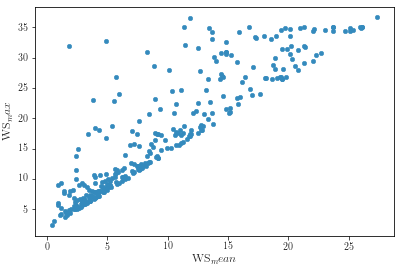

In [14]:
testOG.plot.scatter('WS_mean', 'WS_max')

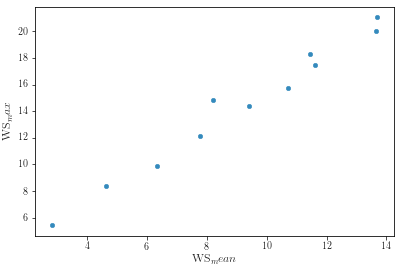

In [15]:
test.plot.scatter('WS_mean', 'WS_max')